In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon, rankdata, t
import scikit_posthocs as sp
import itertools
import math
from matplotlib.lines import Line2D
from collections import defaultdict
from typing import List, Tuple
from collections import defaultdict
import textwrap
from scipy.stats import ttest_rel
import re
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [11]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [12]:
def calculate_smape(actual, predicted):
    
        # Convert actual and predicted to numpy
        # array data type if not already
        if not all([isinstance(actual, np.ndarray), 
                    isinstance(predicted, np.ndarray)]):
            actual, predicted = np.array(actual),
            np.array(predicted)
    
        return round(
            np.mean(
                np.abs(predicted - actual) / 
                ((np.abs(predicted) + np.abs(actual))/2)
            )*100, 2
        )

def calc_metrics(preds_df,model_type,rpi,filter,csv_name):


    if os.path.exists(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}'):
        # print(f'{csv_name} already exists. Loading metrics per inst.')
        return pd.read_csv(f'Results/{model_type}/{rpi}/{filter}/metrics_per_inst/{csv_name}')

    print(f"Processing: {model_type}, {rpi}, {filter}, {csv_name}")
    metrics_per_inst, selected_resources_obs, selected_resources_prds = [], [], []
    selected_resources = ['cpu_user_time_diff', 'cpu_system_time_diff', 'cpu_idle_time_diff', 'memory']
    
    columns = preds_df.columns
    for col in columns:
        if 'obs' in col:
            selected_resources_obs.append(col)
        elif 'preds' in col:
            selected_resources_prds.append(col)
    
    def calculate_one_minus_r2(observations, predictions):

        true_values = [float(x) for x in observations]
        predicted_values = [float(x) for x in predictions]

        return 1 - r2_score(true_values, predicted_values)

    for obs, preds, res in zip(selected_resources_obs, selected_resources_prds, selected_resources):

        # Calculate metrics
        preds_df[res+'_MAE'] = preds_df.apply(lambda row: round(mean_absolute_error([row[obs]], [row[preds]]),3), axis=1)
        metrics_per_inst.append(res+'_MAE')
        preds_df[res+'_RMSE'] = preds_df.apply(lambda row: round(mean_squared_error([row[obs]], [row[preds]], squared=False),3), axis=1)
        metrics_per_inst.append(res+'_RMSE')
        # preds_df[res+'_1-R^2'] = preds_df.apply(lambda row: round(calculate_one_minus_r2([row[obs]], [row[preds]]),3), axis=1)
        # metrics_per_inst.append(res+'_1-R^2')
        preds_df[res+'_MAPE'] = preds_df.apply(lambda row: round(mean_absolute_percentage_error([row[obs]], [row[preds]])*100,2), axis=1)
        metrics_per_inst.append(res+'_MAPE')
        preds_df[res+'_SMAPE'] = preds_df.apply(lambda row: round(calculate_smape(np.array(row[obs]), np.array(row[preds])),2), axis=1)
        metrics_per_inst.append(res+'_SMAPE')
        
    result_df = preds_df[metrics_per_inst]

    os.makedirs(os.path.join('Results', model_type, rpi, filter,'metrics_per_inst'), exist_ok=True)

    print('Saving metrics to {}'.format(csv_name))
    # Save metrics to a CSV file
    result_df.to_csv(r'Results/{}/{}/{}/metrics_per_inst/{}'.format(model_type,rpi,filter,csv_name), index=False)

    return result_df


def get_step_size_name(step_size):
    step_size_dict = {'1Step': '1-step', '2Step': '2-step', '5Step': '5-step', '10Step': '10-step', '15Step': '15-step'}
    return step_size_dict.get(step_size)

def get_filter_name(filter_name):
    filter_dict = {'':'No Filter', '_sg_5_2' : 'SavGol', '_sma_2': 'SMA', '_ema_1':'EMA' }
    return filter_dict.get(filter_name)

def get_sequence_name(sequence_name):
    sequence_dict = {'random':'Random', 'pattern': 'Patterned'}
    return sequence_dict.get(sequence_name)

def get_model_name(model_name):
    model_dict = {'kNN-TSPI':'kNN-TSPI', 'HSMM' : 'RUMP', 'Encoder-Decoder': 'HBLED','HBPSHPO': 'HBPSHPO' }
    return model_dict.get(model_name)

def shoelace_formula(x, y):
    """
    The Shoelace formula, also known as Gauss's area formula 
    or the surveyor's formula, is a method for calculating 
    the area of a simple polygon with known vertex coordinates. 
    The formula is named "Shoelace" because of the pattern the 
    multiplications create, which resembles lacing up a shoe.
    """
    return 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(-1, len(x) - 1)))




def perform_friedman_nemenyi_wilcoxon_tests(data, prds_data):
    """
    Perform Friedman test, Wilcoxon test, and Nemenyi test to compute critical difference diagram.
    """
    # Perform Friedman test

    # Check if there are at least 3 sets of samples
    if data.shape[1] >= 3:
      friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in data.columns])
      print(f"Friedman Test Results for {data.columns.get_level_values('Model_Sequence')}:")
      print(f"  Stat: {friedman_stat}")
      print(f"  P-value: {friedman_p}\n")
      wilcoxon_p = 1
    else:
      # Perform Wilcoxon test for each pair of columns
      print(f"Wilcoxon Test Results  for {data.columns.get_level_values('Model_Sequence')}::")
      for i, col1 in enumerate(data.columns):
        for j, col2 in enumerate(data.columns):
          if i < j:
            wilcoxon_stat, wilcoxon_p = wilcoxon(data[col1], data[col2])
            print(f"  {col1} vs {col2}:")
            print(f"    Stat: {wilcoxon_stat}")
            print(f"    P-value: {wilcoxon_p}\n")
            friedman_p = 1

    # check if prds_data (dataframe) is not empty
    if not prds_data.empty and (friedman_p < 0.05 or wilcoxon_p < 0.05):
        # Perform Nemenyi test
        metrics = prds_data.columns.to_list()
        metrics.remove('Model_Sequence')
        nemenyi_dfs = []
        for metric in metrics:

            
            # Extract the relevant column and group by the Model_Sequence
            grouped_data = prds_data[[metric, 'Model_Sequence']].groupby('Model_Sequence')
            # Transform the grouped data into a format suitable for the Nemenyi test
            data_for_nemenyi = [group[metric].values for _, group in grouped_data]

            # Perform the Nemenyi test
            nemenyi_result = sp.posthoc_nemenyi(data_for_nemenyi)

            print("Nemenyi Test Results:")
            print(nemenyi_result)

            # Convert the Nemenyi result to a DataFrame with appropriate column and index names
            nemenyi_dfs.append(pd.DataFrame(nemenyi_result, columns=data.columns, index=data.columns))
        
        return pd.concat(nemenyi_dfs)
    else:
        return None

def calculate_critical_difference(nemenyi_df, alpha=0.05):
    """
    Calculate the critical difference.
    """
    k = nemenyi_df.shape[1]
    N = nemenyi_df.shape[0]

    q_alpha = t.ppf(1 - alpha / (2 * k * (k - 1)), N - 1)
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))
    print(f"Critical difference: {cd:.3f}")
    return cd


def plot_critical_difference(nemenyi_df, step_size, cd, filename=None):
    """
    Plot the critical difference diagram using matplotlib.
    """
    average_ranks = pd.Series(nemenyi_df.apply(lambda x: rankdata(x, method="average"), axis=1).mean())

    # Sort average_ranks and names
    average_ranks = average_ranks.sort_values()
    sorted_indices = average_ranks.index
    names = nemenyi_df.columns[sorted_indices]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.subplots_adjust(left=0.1, right=0.9)

    ax.set_xlim(-0.5, len(average_ranks) - 0.5)
    ax.set_ylim(0, 1)
    ax.spines["top"].set_position(("axes", 0.6))
    ax.xaxis.set_ticks_position("top")
    ax.yaxis.set_visible(False)
    #increase ticks size
    ax.tick_params(axis='both', which='major', labelsize=22)

    for pos in ["bottom", "left", "right"]:
        ax.spines[pos].set_visible(False)

    # CD bar
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1 - cd], [0.9, 0.9], color="k")
    ax.plot([len(average_ranks) - 1, len(average_ranks) - 1], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.plot([len(average_ranks) - 1 - cd, len(average_ranks) - 1 - cd], [0.9 - 0.03, 0.9 + 0.03], color="k")
    ax.text(len(average_ranks) - 1 - cd / 4.0, 0.92, "CD", ha="center", va="bottom", fontsize=26)

    # Pairwise comparisons
    comparisons = []
    for i, col1 in enumerate(names):
        for j, col2 in enumerate(names):
            if i < j:
                p_value = nemenyi_df.loc[col1, col2]
                if p_value.any() < 0.05:
                    comparisons.append((i, j))

    # for i, j in comparisons:
    #     ax.plot([i, j], [0.9, 0.9], color="k", lw=1)
    #     ax.plot([i, i], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)
    #     ax.plot([j, j], [0.9 - 0.03, 0.9 + 0.03], color="k", lw=1)

    # Annotations
    for (i, j), name in zip(comparisons, names):
        print(name)
        ax.plot([i, i], [0.62, 0.55], color="k", lw=3)
        wrapped_name = textwrap.fill(str(name[1].split("_")[0])+'_'+str(("_".join(name[1].split("_")[1:]))), width=30)  # Wrap the name if it's too long
        level = (i % 3) * 0.19  # Alternate between 0, 1, 2, and 3 for separate levels
    
        if i % 3 == 0:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="bottom", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.68], color="k", linestyle="--", lw=1)
        else:
            ax.text(i, 0.72 - level, wrapped_name, ha="center", va="top", multialignment="center", fontsize=30)  # Increase font size
            ax.plot([i, i], [0.72 - level, 0.55], color="k", linestyle="--", lw=1)
        


      
    # ax.set_title(f"Critical Difference Diagram for {step_size}", fontsize=12)
    # plt.tight_layout()

    if filename:
        fig_directory = os.path.join('Figures', 'Experiments', f"{filename}_CD.png")
        plt.savefig(fig_directory, bbox_inches='tight')

    
    plt.show()
    plt.close()



def create_filter_star_chart(data, title, y_lim, filename=None):
    
    scale = 1

    num_vars = len(data.columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    ax = plt.subplot(111, polar=True)
    plt.xticks(angles, data.columns, color='grey', size=14)
    ax.set_rlabel_position(30)
    plt.yticks(color="grey", size=12)
    plt.ylim(0, y_lim * scale)

    groups = defaultdict(list)
    for index, data_values in data.iterrows():
        model_name, model_seq = index
        filter_type = model_seq
        groups[model_name].append((filter_type, data_values))

    areas = {}
    areas_list = []

    # Define color palettes for each group
    group_colors = {
        'Encoder-Decoder': sns.color_palette("Blues_r", len(groups['Encoder-Decoder'])), # Spectral_r, “Greens_r”
        'kNN-TSPI': sns.color_palette("Reds_r", len(groups['kNN-TSPI'])), # “Reds_r”, "Purples_r"
        'HSMM': sns.color_palette("Greens_r", len(groups['HSMM'])), # “Greys_r”
        'HBPSHPO': sns.color_palette("Purples_r", len(groups['HBPSHPO'])) # “Greys_r”
    }
    # all colors: https://seaborn.pydata.org/tutorial/color_palettes.html

    # Define linestylte palettes for each model
    model_linestyles = {
        'Encoder-Decoder': ['-.', '-', '--', ':'],
        'kNN-TSPI': ['-.', '-', '--', ':'],
        'HSMM': ['-.', '-', '--', ':'],
        'HBPSHPO': ['-.', '-', '--', ':']
    }


    for model_name, group_data in groups.items():
        group_color = group_colors.get(model_name)

        for filter_idx, (filter_type, data_values) in enumerate(group_data):
            data_values = np.concatenate((data_values, [data_values[0]]))
            angles_cycle = angles + angles[:1]

            x = data_values * np.cos(angles_cycle)
            y = data_values * np.sin(angles_cycle)

            area = shoelace_formula(x, y)
            model_seq_combo = filter_type
            print(model_seq_combo, area)
            areas_list.append(area)
            areas[model_seq_combo] = area

            # Find the index of the current filter type in the group data
            filter_idx = [x[0] for x in group_data].index(filter_type)

            # Compute the normalized area value
            area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


            # Compute the color for the current polygon based on the group color and the normalized area value
            color = group_color[filter_idx] if group_color else sns.color_palette("dark", 1)[0]
            shade = color if area_value == 0 else sns.blend_palette([color, 'white'], as_cmap=True)(area_value)

            print('Metric values:', data_values)

            # Scale data_values
            data_values = data_values * scale

            ax.plot(angles_cycle, data_values, linewidth=2, linestyle= model_linestyles.get(model_name)[filter_idx] , label=f"{get_model_name(filter_type.split('_')[0])} - {filter_type.split('_')[1]}", color=color)
            ax.fill(angles_cycle, data_values, alpha=0.1, color=color)

            

    normalized_areas = (areas_list - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))
    

    print(title)
    plt.legend(loc='lower right', bbox_to_anchor=(1.7, 0.25), fontsize=12)
    plt.gca().set_facecolor('white')
    

    if filename:
        fig_directory = os.path.join('Figures','Experiments',f"{filename}_Star.png")
        plt.savefig(fig_directory, bbox_inches='tight')
    
    plt.show()
    plt.close()

    return areas



def preprocess_data(data, normalization_method="min_max"):
    
    def min_max_scaling(column):
        return (column - global_min) / (global_max - global_min)

    def z_score_standardization(column):
        return (column - column.mean()) / column.std()

    def log_transformation(column):
        return np.log(column + 1 - column.min())

    def percentile_based_scaling(column):
        return (column - column.median()) / (column.quantile(0.75) - column.quantile(0.25))

    def unit_vector_scaling(column):
        norm = np.sqrt(np.sum(column**2))
        return column / norm

    normalization_methods = {
        "min_max": min_max_scaling,
        "z_score": z_score_standardization,
        "log": log_transformation,
        "percentile": percentile_based_scaling,
        "unit_vector": unit_vector_scaling,
    }

    if normalization_method not in normalization_methods:
        raise ValueError(f"Invalid normalization method: {normalization_method}")

    # Exclude the 'Filter_Type' column during normalization
    numeric_columns = data.select_dtypes(include=[np.number]).columns
    data_normalized = data.copy()

    # Calculate the global min and max for all model/filter combinations
    global_min = data[numeric_columns].min().min()
    global_max = data[numeric_columns].max().max()

    # Apply the selected normalization method
    normalization_func = normalization_methods[normalization_method]
    data_normalized[numeric_columns] = data[numeric_columns].apply(normalization_func)

    return data_normalized



def remove_outliers(data, csv_file, directory):
    # Identify and remove outliers using IQR method
    Q1 = data.quantile(0.05, numeric_only=True)
    Q3 = data.quantile(0.95, numeric_only=True)
    IQR = Q3 - Q1
    
    # Align the DataFrame and Series before making the comparison
    lower_bound, _ = data.align(Q1 - 1.5 * IQR, axis=1, copy=False)
    upper_bound, _ = data.align(Q3 + 1.5 * IQR, axis=1, copy=False)
    
    # Find outliers
    outliers_mask = (data.lt(lower_bound) | data.gt(upper_bound)).any(axis=1)
    
    # Track the number of outliers
    outlier_count = outliers_mask.sum()
    
    # Display information about outliers
    if outlier_count > 0:
        print(f"File: {csv_file} - Total outliers: {outlier_count} - Directory: {directory}")
        print("Outliers count per metric:")
        print((data[outliers_mask]).count())
        print("Sample outlier values:")
        print(data[outliers_mask].head(5))  # Adjust the number of samples as needed
    
    # Remove outliers
    data = data[~outliers_mask]

    return data

def get_metric_per_inst(step_size, models, devices, filters, root_directory, sequences=None):
    preds_data = []
    for model in models:
        predictions_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                for sequence in sequences:

                    try:
                    
                        device_directory_predictions = os.path.join(root_directory, model, device, filter_name, 'predictions')
                        
                        # Get all the csv files in the directory
                        csv_files = [f for f in os.listdir(device_directory_predictions) if f.endswith(step_size + '.csv')]

                        for csv_file in csv_files:
                            
                            predictions_file_path = os.path.join(device_directory_predictions, csv_file)

                            predictions_data = pd.read_csv(predictions_file_path)
                            predictions_data = predictions_data.applymap(parse_float)

                            predictions_data = calc_metrics(predictions_data, model, device, filter_name, csv_file)
                            
                            predictions_data = remove_outliers(predictions_data, csv_file, device_directory_predictions)

                            cols = predictions_data.columns

                            predictions_data['Model_Sequence'] = model+'_'+get_sequence_name(sequence)
                            
                            reshaped_df = pd.DataFrame()
                            # Iterate over each metric and model-filter combination
                            for metric, model_seq in product(cols, predictions_data['Model_Sequence'].unique()):
                                # Create a new column in the reshaped DataFrame for each model-filter combination
                                col_name = f'{metric}_{model_seq}'
                                metric_df = predictions_data.loc[predictions_data['Model_Sequence'] == model_seq, metric]
                                reshaped_df[col_name] = metric_df.values
                            
                            predictions_data_frames.append(predictions_data)

                
                    except:
                        print(f"Missing: {model}, {device}, {filter_name}, {step_size}")
 
        # Organizing Predictions Data
        combined_predictions_data = pd.concat(predictions_data_frames)
        
        preds_data.append(combined_predictions_data)


    return pd.concat(preds_data)

def get_metrics(step_size, models, devices, filters, root_directory, sequences=None, norm = None):
    model_data = []
    for model in models:
        metrics_data_frames = []
        for device in devices:                  
            for filter_name in filters:

                    for sequence in sequences:

                
                        try:
                            device_directory_metrics = os.path.join(root_directory, model, device, filter_name, 'metrics')

                            # Get all the csv files in the directory
                            csv_files = [f for f in os.listdir(device_directory_metrics) if f.endswith(step_size + '.csv')]

                            for csv_file in csv_files:
                                
                                metrics_file_path = os.path.join(device_directory_metrics, csv_file)
                                metrics_data = pd.read_csv(metrics_file_path)

                                # metrics_data = remove_outliers(metrics_data, csv_file, device_directory_metrics)

                                metrics_data['Sequence_Type'] = get_sequence_name(sequence)  # Add a new column with the sequence type
                                metrics_data_frames.append(metrics_data)
                                
                        except:
                            print(f"Missing: {model}, {device}, {filter_name}, {step_size}")

        
        # Organizing Metrics Data
        combined_metrics_data = pd.concat(metrics_data_frames)
        selected_metrics_data = combined_metrics_data[selected_metrics]

        # Create a copy of the selected_data slice
        selected_metrics_data = selected_metrics_data.copy()

        # Transform the R2 score to a value that needs to be minimized
        selected_metrics_data.loc[:, 'Score'] = 1 - selected_metrics_data['Score']
        selected_metrics_data.rename(columns={"Score": "1 - R^2"}, inplace=True)

        selected_metrics_data['Sequence_Type'] = combined_metrics_data['Sequence_Type']  # Copy the 'Filter_Type' column before preprocessing
        
        # Preprocess the data
        if norm is not None:
            preprocessed_metrics_data = preprocess_data(selected_metrics_data,normalization_method=norm) # "unit_vector", "log", "min_max","z_score","percentile"
        else:
            preprocessed_metrics_data = selected_metrics_data

        # unit-vector Using unit vector normalization (also known as L2 normalization) 
        # scales each data point so that it has a magnitude of 1. 
        # This means that the comparisons between data points
        #  will be based on the direction (the proportions of the different metrics)
        #  rather than the magnitude (the absolute values of the metrics).

        # print(model)  # Print the model name
        # print("Preprocessed data by model/filter combination:")
        # print(preprocessed_metrics_data.groupby('Sequence_Type').describe())  # Print the description of the preprocessed data by filter type

        mean_values = preprocessed_metrics_data.groupby('Sequence_Type').mean().reset_index()  # Group by Filter_Type and calculate mean
        mean_values['Model'] = model  # Add a new column with the model name
        mean_values['Model_Sequence'] = model + '_' + mean_values['Sequence_Type']  # Create a combined column for model and filter
        mean_values = mean_values.set_index(['Model', 'Model_Sequence'])  # Set the new 'Model_Sequence' column as the index along with 'Model'
        mean_values = mean_values.drop(columns=['Sequence_Type'])  # Drop the original 'Sequence_Type' column

        model_data.append(mean_values)


    return pd.concat(model_data)



def parse_float(value):
    try:
        if isinstance(value, str):
            # Extract the float from the string
            match = re.search(r"[-+]?\d*\.\d+|\d+", value)
            if match:
                value = float(match.group(0))
            else:
                value = np.nan
        return float(value)
    except ValueError:
        return np.nan

In [13]:
models = ['HSMM','HBPSHPO'] #, 'kNN-TSPI', 'Encoder-Decoder'
devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
sequences = ['random','pattern']
step_sizes = ['30Step','60Step'] #'1Step', '2Step', '5Step', '10Step','15Step' 
filters = ['']# '','_sg_5_2','_ema_1','_sma_2' ]
# fig_name = "All_models_"+ step_size
ylimit = 0.13

# models = ['kNN-TSPI', 'Encoder-Decoder'] #, 'HSMM' 
# devices = ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
# step_sizes = [ '1Step']#, '2Step', '5Step', '10Step', '15Step'] 
# filters = ['_ema_1','','_sg_5_2'] #,'_sma_2'
# fig_name = None # step_size
# ylimit = 0.6

In [14]:
normalizer = "unit_vector" # "unit_vector"
root_directory = 'Results'
selected_metrics = ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 30Step
Processing: HBPSHPO, RPi4B8GB, , RPi4B8GB_1800MHz_pattern_30Step.csv
Saving metrics to RPi4B8GB_1800MHz_pattern_30Step.csv
Processing: HBPSHPO, RPi4B8GB, , RPi4B8GB_1800MHz_random_30Step.csv
Saving metrics to RPi4B8GB_1800MHz_random_30Step.csv
Processing: HBPSHPO, RPi4B4GB, , RPi4B4GB_1500MHz_pattern_30Step.csv
Saving metrics to RPi4B4GB_1500MHz_pattern_30Step.csv
Processing: HBPSHPO, RPi4B4GB, , RPi4B4GB_1500MHz_random_30Step.csv
Saving metrics to RPi4B4GB_1500MHz_random_30Step.csv
Processing: HBPSHPO, RPi4B2GB2, , RPi4B2GB2_1500MHz_pattern_30Step.csv
Saving metrics to RPi4B2GB2_1500MHz_pattern_30Step.csv
Processing: HBPSHPO, RPi4B2GB2, , RPi4B2GB2_1500MHz_random_30Step.csv
Saving metrics to RPi4B2GB2_1500MHz_random_30Step.csv
Processing: HBPSHPO, RPi4B2GB1, , RPi4B2GB1_1200MHz_pattern_30Step.csv
Saving metrics to RPi4B2GB1_1200MHz_pattern_30Step.csv
Processing: HBPSHPO, RPi4B2GB1, , RPi4B2GB1_1200MHz_random_30Step.csv
Saving metrics to RPi4B2GB1_1200MHz_random_30Ste

<ipython-input-12-3b5baa1f69ed>:299: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


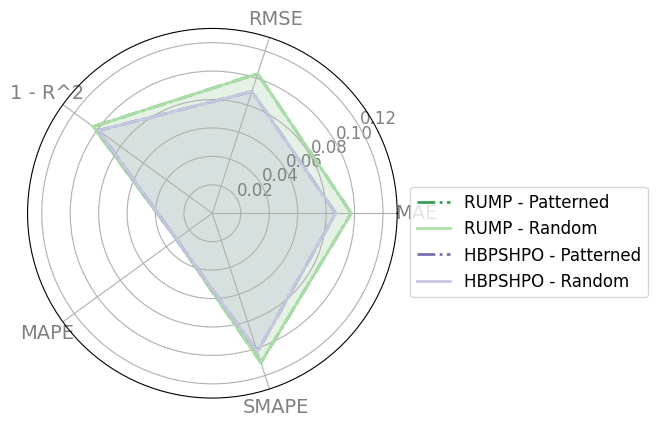

Areas for None:
HSMM_Patterned: 0.01820409340068454
HSMM_Random: 0.01820409340068454
HBPSHPO_Patterned: 0.015179131663336237
HBPSHPO_Random: 0.015179131663336237

Step Size: 60Step
Processing: HSMM, RPi4B2GB1, , RPi4B2GB1_1200MHz_random_60Step.csv
Missing: HSMM, RPi4B2GB1, , 60Step
Processing: HSMM, RPi4B2GB1, , RPi4B2GB1_1200MHz_random_60Step.csv
Missing: HSMM, RPi4B2GB1, , 60Step
Processing: HBPSHPO, RPi4B8GB, , RPi4B8GB_1800MHz_pattern_60Step.csv
Saving metrics to RPi4B8GB_1800MHz_pattern_60Step.csv
Processing: HBPSHPO, RPi4B8GB, , RPi4B8GB_1800MHz_random_60Step.csv
Saving metrics to RPi4B8GB_1800MHz_random_60Step.csv
Processing: HBPSHPO, RPi4B4GB, , RPi4B4GB_1500MHz_pattern_60Step.csv
Saving metrics to RPi4B4GB_1500MHz_pattern_60Step.csv
Processing: HBPSHPO, RPi4B4GB, , RPi4B4GB_1500MHz_random_60Step.csv
Saving metrics to RPi4B4GB_1500MHz_random_60Step.csv
Processing: HBPSHPO, RPi4B2GB2, , RPi4B2GB2_1500MHz_pattern_60Step.csv
Saving metrics to RPi4B2GB2_1500MHz_pattern_60Step.csv
P

<ipython-input-12-3b5baa1f69ed>:299: RuntimeWarning: invalid value encountered in scalar divide
  area_value = (area - np.min(areas_list)) / (np.max(areas_list) - np.min(areas_list))


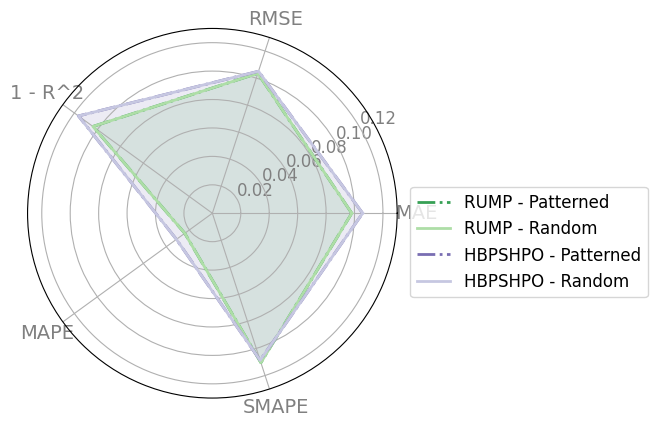

Areas for None:
HSMM_Patterned: 0.017541474363020525
HSMM_Random: 0.017541474363020525
HBPSHPO_Patterned: 0.019906542706052723
HBPSHPO_Random: 0.019906542706052723



In [15]:
# Run - Encoder-Decoder - kNN-TSPI  - HSMM - (No Filter, EMA) - Not normalized
# print('Encoder-Decoder - kNN-TSPI  - HSMM - (No Filter, EMA) - Not normalized')

areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, sequences, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory, sequences)

    # Plot the star chart and get the areas
    model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    areas_dict[step_size] = model_areas
    print(f'Areas for {get_step_size_name(step_size)}:')
    for model_seq_combo, area in model_areas.items():
        print(f'{model_seq_combo}: {area}')
    print()

    # # Transpose the dataframe to compare models instead of metrics
    # metrics_df_transposed = metrics_df.T

    # # predictions_df_transposed = predictions_df.T

    # nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    # #check if nemenyi_df is not None
    # if nemenyi_df is not None:
    #     # Calculate the critical difference
    #     cd = calculate_critical_difference(nemenyi_df)
        
    #     # # Plot the critical difference diagram
    #     plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    # else:
    #     print("No significant difference found for:")

    #     print()

    #     print('Step Size:', step_size)
    #     print('Models:', models)
    #     print('Devices:', devices)
    #     print("Filters:", filters)
    #     print('Selected Metrics:', selected_metrics)
        
    #     print()

In [16]:
normalizer = None # "unit_vector"
root_directory = 'Results'
selected_metrics = ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 30Step
Friedman Test Results for Index(['HSMM_Patterned', 'HSMM_Random', 'HBPSHPO_Patterned', 'HBPSHPO_Random'], dtype='object', name='Model_Sequence'):
  Stat: 0.600000000000005
  P-value: 0.8964323733419103

No significant difference found for:

Step Size: 30Step
Models: ['HSMM', 'HBPSHPO']
Devices: ['RPi4B8GB', 'RPi4B4GB', 'RPi4B2GB2', 'RPi4B2GB1']
Filters: ['']
Selected Metrics: ['MAE', 'RMSE', 'Score', 'MAPE', 'SMAPE']

Step Size: 60Step
Processing: HSMM, RPi4B2GB1, , RPi4B2GB1_1200MHz_random_60Step.csv
Missing: HSMM, RPi4B2GB1, , 60Step
Processing: HSMM, RPi4B2GB1, , RPi4B2GB1_1200MHz_random_60Step.csv
Missing: HSMM, RPi4B2GB1, , 60Step
Friedman Test Results for Index(['HSMM_Patterned', 'HSMM_Random', 'HBPSHPO_Patterned', 'HBPSHPO_Random'], dtype='object', name='Model_Sequence'):
  Stat: 15.0
  P-value: 0.0018166489665723214

Nemenyi Test Results:
     1    2    3    4
1  1.0  1.0  0.0  0.0
2  1.0  1.0  0.0  0.0
3  0.0  0.0  1.0  1.0
4  0.0  0.0  1.0  1.0
Nemenyi Test 

<ipython-input-12-3b5baa1f69ed>:200: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_value = nemenyi_df.loc[col1, col2]


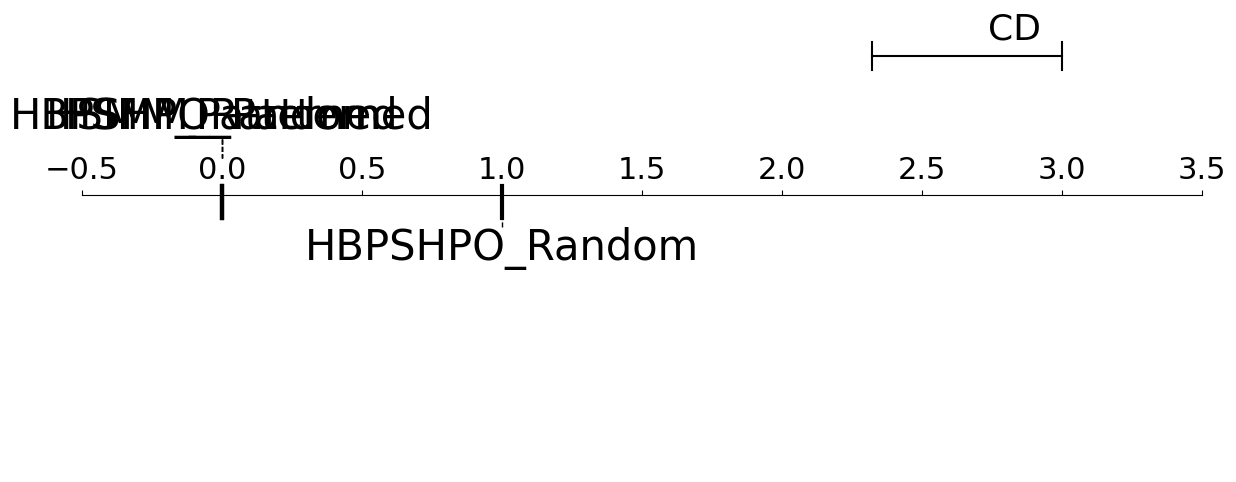

In [17]:
# Run - Encoder-Decoder - kNN-TSPI  - HSMM - (No Filter, EMA) - Not normalized
# print('Encoder-Decoder - kNN-TSPI  - HSMM - (No Filter, EMA) - Not normalized')

areas_dict = {}

# for step_size in ['1Step', '2Step', '5Step', '10Step', '15Step']:
for step_size in step_sizes:
    print('Step Size:', step_size)

    fig_name = None # "All_models_"+ step_size
    
    # Get the metrics for the given step size
    metrics_df = get_metrics(step_size, models, devices, filters, root_directory, sequences, normalizer)
    predictions_df = get_metric_per_inst(step_size, models, devices, filters, root_directory, sequences)

    # # Plot the star chart and get the areas
    # model_areas = create_filter_star_chart(metrics_df, f'Star Chart for {get_step_size_name(step_size)}', ylimit, fig_name)
    # areas_dict[step_size] = model_areas
    # print(f'Areas for {get_step_size_name(step_size)}:')
    # for model_seq_combo, area in model_areas.items():
    #     print(f'{model_seq_combo}: {area}')
    # print()

    # Transpose the dataframe to compare models instead of metrics
    metrics_df_transposed = metrics_df.T

    # predictions_df_transposed = predictions_df.T

    nemenyi_df = perform_friedman_nemenyi_wilcoxon_tests(metrics_df_transposed, predictions_df)

    #check if nemenyi_df is not None
    if nemenyi_df is not None:
        # Calculate the critical difference
        cd = calculate_critical_difference(nemenyi_df)
        
        # # Plot the critical difference diagram
        plot_critical_difference(nemenyi_df, step_size, cd, fig_name)
    else:
        print("No significant difference found for:")

        print()

        print('Step Size:', step_size)
        print('Models:', models)
        print('Devices:', devices)
        print("Filters:", filters)
        print('Selected Metrics:', selected_metrics)
        
        print()